Importing libraries

In [ ]:
!pip install accelerate -U

import sys
import sklearn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import nltk
import re
import string
import torch

from transformers import Trainer, TrainingArguments
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import AlbertTokenizer, AlbertForSequenceClassification
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from torch.optim import AdamW
from accelerate import Accelerator
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from pandas import DataFrame
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from torch.utils.data import DataLoader, TensorDataset

Load data from files into a single dataframe with 3 columns: title, text, label

In [ ]:
tweetsData = pd.read_csv('drive/MyDrive/datasets/Truth_Seeker_Model_Dataset.csv');
tweetsData['text'] = tweetsData['tweet'];
tweetsData['label'] = tweetsData['target'].replace({True: 'real', False: 'fake'});


labeled_data = pd.concat([tweetsData[['text', 'label']]]);
labeled_data = labeled_data.dropna();
labeled_data = labeled_data.sample(frac=1, random_state=42).reset_index(drop=True)
labeled_data = labeled_data.head(50000)
print(labeled_data.info());

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    50000 non-null  object
 1   label   50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None


Visualize the distribution of 'real' and 'fake' news

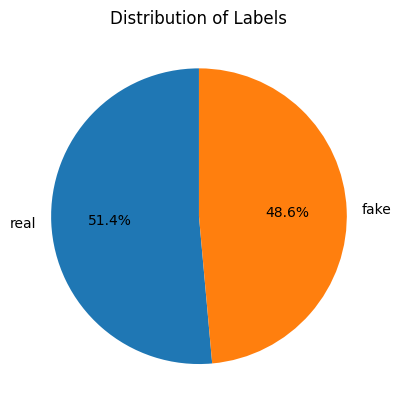

In [ ]:
#Visualize data
label_counts = labeled_data['label'].value_counts();
fig, ax = plt.subplots();
ax.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=90);
ax.set_aspect('equal');  # Equal aspect ratio so that the pie chart is circular
ax.set_title('Distribution of Labels');
plt.show();

Prepare data by processing text. Remove stopwords from the data, whitespaces, URLs, non-alphanumeric characters etc

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords');
nltk.download('punkt');

stop_words2 = set(stopwords.words('english'));

def remove_stopwords(text):
   tokens = word_tokenize(text);
   filtered_tokens = [word for word in tokens if word.lower() not in stop_words2];
   filtered_text = ' '.join(filtered_tokens);
   return filtered_text;

def process_text(text):
    text = text.lower().split();
    text = " ".join(text); #remove extra whitespaces
    text = re.sub('\n', '', text); #remove newlines
    return text;

labeled_data_processed = labeled_data

# Remove stopwords from the 'text' column
#labeled_data_processed['text'] = labeled_data['text'].apply(remove_stopwords);
#print("Removed stopwords");
labeled_data_processed['text'] = labeled_data['text'].apply(process_text);
print("Finished processing text");

Finished processing text


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Splitting data into training and testing datasets. 80% of the total dataset will be used for training, and the remaining 20% will be used to test the performance of the model

In [ ]:
x_features = labeled_data_processed[['text']];
x_features['combined_text'] = x_features['text'];
x = x_features['combined_text'];

y = labeled_data_processed['label'];

vectorizer = TfidfVectorizer(stop_words='english');
x_vectorized = vectorizer.fit_transform(x);

# Split the data into training and testing datasets
x_train, x_test, y_train, y_test = train_test_split(x_vectorized, y, test_size=0.2, random_state=30);
print('Training dataset size: ' + str(x_train.shape[0]));
print('Testing dataset size: ' + str(x_test.shape[0]));

Training dataset size: 40000
Testing dataset size: 10000



# Training models
Logistic regression model

In [ ]:
# Train model
logistic_regression_model = LogisticRegression(max_iter=1000);
logistic_regression_model.fit(x_train, y_train);

# Test model and stats
y_predicted = logistic_regression_model.predict(x_test);

accuracy = accuracy_score(y_test, y_predicted);
print("Accuracy:", accuracy);

print("\nClassification Report:");
print(classification_report(y_test, y_predicted));

Accuracy: 0.9665

Classification Report:
              precision    recall  f1-score   support

        fake       0.97      0.96      0.97      4875
        real       0.96      0.97      0.97      5125

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



Support vector machine (SVM) model

In [ ]:
svm_classifier = SVC(kernel='linear');  # You can choose different kernels (e.g., 'linear', 'rbf')

# Train model
svm_classifier.fit(x_train, y_train);

# Test model and stats
y_predicted = svm_classifier.predict(x_test);

accuracy = accuracy_score(y_test, y_predicted);
print("Accuracy:", accuracy);

print("\nClassification Report:");
print(classification_report(y_test, y_predicted));

Accuracy: 0.9761

Classification Report:
              precision    recall  f1-score   support

        fake       0.98      0.97      0.98      4875
        real       0.97      0.98      0.98      5125

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



Multinomial Naive Bayes (MNB) model

In [ ]:
naive_bayes_classifier = MultinomialNB();

# Train model
naive_bayes_classifier.fit(x_train, y_train);

# Test model and stats
y_predicted = naive_bayes_classifier.predict(x_test);

accuracy = accuracy_score(y_test, y_predicted);
print("Accuracy:", accuracy);

print("\nClassification Report:");
print(classification_report(y_test, y_predicted));

Accuracy: 0.946

Classification Report:
              precision    recall  f1-score   support

        fake       0.95      0.94      0.94      4875
        real       0.94      0.96      0.95      5125

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



# Predict manual input

In [ ]:
def predict_article(label_model, tfidf_vectorizer, post_text):
    vectorized_input = tfidf_vectorizer.transform([post_text]);
    predicted_label = label_model.predict(vectorized_input);
    return predicted_label[0];

def remove_stopwords(text):
   tokens = word_tokenize(text);
   filtered_tokens = [word for word in tokens if word.lower() not in stop_words2];
   filtered_text = ' '.join(filtered_tokens);
   return filtered_text;

def process_text(text):
    text = text.lower().split();
    text = " ".join(text); #remove extra whitespaces
    text = re.sub('\n', '', text); #remove newlines
    return text;


#Input post title and text
post_text = input("Enter post text: ");
#post_text = remove_stopwords(post_text);
post_text = process_text(post_text);

#maybe add processing to input, such as removing stopwords

predicted_label = predict_article(logistic_regression_model, vectorizer, post_text);
print("Logistic regression predicted label:", predicted_label);

Enter post text: @JoshuaHosler Jacob Blake had a knife, and told officers he had a gun in his car and was going to get it, he was tased, it had no effect. He did not follow simple orders from the officers,  He resisted, n had sexual assault warrants, He made it to his car, opened the door, reached for his gun.
Logistic regression predicted label: fake


# Hugging transformer models
There is a lack of Hugging transformer models use

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords');
nltk.download('punkt');

stop_words2 = set(stopwords.words('english'));

def remove_stopwords(text):
   tokens = word_tokenize(text);
   filtered_tokens = [word for word in tokens if word.lower() not in stop_words2];
   filtered_text = ' '.join(filtered_tokens);
   return filtered_text;

def process_text(text):
    text = text.lower().split();
    text = " ".join(text); #remove extra whitespaces
    text = re.sub('\n', '', text); #remove newlines
    return text;

labeled_data_processed = labeled_data

# Remove stopwords from the 'text' column
#labeled_data_processed['text'] = labeled_data_processed['text'].apply(remove_stopwords);
#print("Removed stopwords");
labeled_data_processed['text'] = labeled_data_processed['text'].apply(process_text);
print("Finished processing text");

x_features = labeled_data_processed[['text']];
x_features['combined_text'] = x_features['text'];
x = x_features['combined_text'];

y = labeled_data_processed['label'];

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=30);

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Finished processing text


BERT-base-cased model


In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification

# Initialize tokenizer and model and switch to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu");
print("Device is " + str(device));
tokenizer = BertTokenizer.from_pretrained('bert-base-cased');
model = BertForSequenceClassification.from_pretrained('bert-base-cased', num_labels=2).to(device);

# Tokenize the input data
x_train_encodings = tokenizer(x_train.tolist(), truncation=True, padding=True, return_tensors='pt').to(device);
x_test_encodings = tokenizer(x_test.tolist(), truncation=True, padding=True, return_tensors='pt').to(device);

# Convert labels to integers
label_map = {'real': 0, 'fake': 1};
y_train_encoded = y_train.map(label_map);
y_test_encoded = y_test.map(label_map);

train_dataset = TensorDataset(
    x_train_encodings['input_ids'].clone().detach(),
    x_train_encodings['attention_mask'].clone().detach(),
    torch.tensor(y_train_encoded.values).to(device)
);

test_dataset = TensorDataset(
    x_test_encodings['input_ids'].clone().detach(),
    x_test_encodings['attention_mask'].clone().detach(),
    torch.tensor(y_test_encoded.values).to(device)
);

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True);
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False);

optimizer = AdamW(model.parameters(), lr=5e-5);

# Train the model
model.train();
for epoch in range(3):
    for batch in train_loader:
        input_ids, attention_mask, labels = batch;
        optimizer.zero_grad();
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels);
        loss = outputs.loss;
        loss.backward();
        optimizer.step();

# Evaluate the model
model.eval();
predictions = [];
true_labels = [];
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch;
        outputs = model(input_ids=input_ids, attention_mask=attention_mask);
        logits = outputs.logits;
        predicted_labels = torch.argmax(logits, dim=1);
        predictions.extend(predicted_labels.tolist());
        true_labels.extend(labels.tolist());

# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions);
print("Accuracy:", accuracy);

# Classification report
print("\nClassification Report:");
print(classification_report(true_labels, predictions));

#Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predictions);
print("Confusion Matrix:");
print(conf_matrix);

Device is cuda


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 0.9833

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      5125
           1       0.99      0.97      0.98      4875

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

Confusion Matrix:
[[5087   38]
 [ 129 4746]]


ALBERT-base model


In [ ]:
from transformers import AlbertTokenizer, AlbertForSequenceClassification

# Initialize tokenizer and model and switch to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu");
print("Device is " + str(device));
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2');
albert_model = AlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=2).to(device);

# Tokenize the input data
x_train_encodings = tokenizer(x_train.tolist(), truncation=True, padding=True, return_tensors='pt').to(device);
x_test_encodings = tokenizer(x_test.tolist(), truncation=True, padding=True, return_tensors='pt').to(device);

# Convert labels to integers
label_map = {'real': 0, 'fake': 1};
y_train_encoded = y_train.map(label_map);
y_test_encoded = y_test.map(label_map);

train_dataset = TensorDataset(
    x_train_encodings['input_ids'].clone().detach(),
    x_train_encodings['attention_mask'].clone().detach(),
    torch.tensor(y_train_encoded.values).to(device)
);

test_dataset = TensorDataset(
    x_test_encodings['input_ids'].clone().detach(),
    x_test_encodings['attention_mask'].clone().detach(),
    torch.tensor(y_test_encoded.values).to(device)
);

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True);
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False);

optimizer = AdamW(albert_model.parameters(), lr=5e-5);

# Train the model
albert_model.train();
for epoch in range(3):
    for batch in train_loader:
        input_ids, attention_mask, labels = batch;
        optimizer.zero_grad();
        outputs = albert_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels);
        loss = outputs.loss;
        loss.backward();
        optimizer.step();

# Evaluate the model
albert_model.eval();
predictions = [];
true_labels = [];
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch;
        outputs = albert_model(input_ids=input_ids, attention_mask=attention_mask);
        logits = outputs.logits;
        predicted_labels = torch.argmax(logits, dim=1);
        predictions.extend(predicted_labels.tolist());
        true_labels.extend(labels.tolist());

# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions);
print("Accuracy:", accuracy);

# Classification report
print("\nClassification Report:");
print(classification_report(true_labels, predictions));

#Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predictions);
print("Confusion Matrix:");
print(conf_matrix);

Device is cuda


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 0.9625

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      5125
           1       0.99      0.94      0.96      4875

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

Confusion Matrix:
[[5056   69]
 [ 306 4569]]


RoBERTa model

Took 30 min

Accuracy with removed stopwords: 0.97
Accuracy without removed stopwords: 0.97


In [ ]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification

# Initialize tokenizer and model and switch to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu");
print("Device is " + str(device));
tokenizer = RobertaTokenizer.from_pretrained('roberta-base');
roberta_model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2).to(device);

# Tokenize the input data
x_train_encodings = tokenizer(x_train.tolist(), truncation=True, padding=True, return_tensors='pt').to(device);
x_test_encodings = tokenizer(x_test.tolist(), truncation=True, padding=True, return_tensors='pt').to(device);

# Convert labels to integers
label_map = {'real': 0, 'fake': 1};
y_train_encoded = y_train.map(label_map);
y_test_encoded = y_test.map(label_map);

train_dataset = TensorDataset(
    x_train_encodings['input_ids'].clone().detach(),
    x_train_encodings['attention_mask'].clone().detach(),
    torch.tensor(y_train_encoded.values).to(device)
);

test_dataset = TensorDataset(
    x_test_encodings['input_ids'].clone().detach(),
    x_test_encodings['attention_mask'].clone().detach(),
    torch.tensor(y_test_encoded.values).to(device)
);

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

optimizer = AdamW(roberta_model.parameters(), lr=5e-5);

# Train the model
roberta_model.train();
for epoch in range(3):
    for batch in train_loader:
        input_ids, attention_mask, labels = batch;
        optimizer.zero_grad();
        outputs = roberta_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels);
        loss = outputs.loss;
        loss.backward();
        optimizer.step();

# Evaluate the model
roberta_model.eval();
predictions = [];
true_labels = [];
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch;
        outputs = roberta_model(input_ids=input_ids, attention_mask=attention_mask);
        logits = outputs.logits;
        predicted_labels = torch.argmax(logits, dim=1);
        predictions.extend(predicted_labels.tolist());
        true_labels.extend(labels.tolist());

# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions);
print("Accuracy:", accuracy);

# Classification report
print("\nClassification Report:");
print(classification_report(true_labels, predictions));

#Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predictions);
print("Confusion Matrix:");
print(conf_matrix);

Device is cuda


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 0.9829

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      5125
           1       0.99      0.98      0.98      4875

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

Confusion Matrix:
[[5071   54]
 [ 117 4758]]


Save trained Roberta model

In [ ]:
roberta_model.save_pretrained("drive/MyDrive/models/robertaTweets/");
tokenizer.save_pretrained("drive/MyDrive/models/robertaTweets/");

Load trained Roberta model

In [ ]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu");
loaded_model = RobertaForSequenceClassification.from_pretrained("drive/MyDrive/models/robertaTweets/").to(device);
loaded_tokenizer = RobertaTokenizer.from_pretrained("drive/MyDrive/models/robertaTweets/");

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu");
print("Device is " + str(device));

# Tokenize the input data
x_test_encodings = loaded_tokenizer(x_test.tolist(), truncation=True, padding=True, return_tensors='pt').to(device);

# Convert labels to integers
label_map = {'real': 0, 'fake': 1};
y_test_encoded = y_test.map(label_map);

test_dataset = TensorDataset(
    x_test_encodings['input_ids'].clone().detach(),
    x_test_encodings['attention_mask'].clone().detach(),
    torch.tensor(y_test_encoded.values).to(device)
);

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False);

# Evaluate the model
loaded_model.eval();
predictions = [];
true_labels = [];
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch;
        outputs = loaded_model(input_ids=input_ids, attention_mask=attention_mask);
        logits = outputs.logits;
        predicted_labels = torch.argmax(logits, dim=1);
        predictions.extend(predicted_labels.tolist());
        true_labels.extend(labels.tolist());

# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions);
print("Accuracy:", accuracy);

# Classification report
print("\nClassification Report:");
print(classification_report(true_labels, predictions));

#Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predictions);
print("Confusion Matrix:");
print(conf_matrix);

Device is cuda
Accuracy: 0.9829

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      5125
           1       0.99      0.98      0.98      4875

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

Confusion Matrix:
[[5071   54]
 [ 117 4758]]


# Graphs

Make some graphs to better visualise data

In [ ]:
tweetsData = pd.read_csv('drive/MyDrive/datasets/Truth_Seeker_Model_Dataset.csv');
tweetsData['text'] = tweetsData['tweet'];
tweetsData['label'] = tweetsData['target'].replace({True: 'real', False: 'fake'});


labeled_data = pd.concat([tweetsData[['text', 'label']]]);
labeled_data = labeled_data.dropna();
labeled_data = labeled_data.sample(frac=1, random_state=42).reset_index(drop=True)
labeled_data = labeled_data.head(50000)
print(labeled_data.info());

fake_data = labeled_data[labeled_data['label'] == 'fake']
print(fake_data.info());

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    50000 non-null  object
 1   label   50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 24286 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    24286 non-null  object
 1   label   24286 non-null  object
dtypes: object(2)
memory usage: 569.2+ KB
None


In [ ]:
#Remove stopwords for most frequently used words
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords');
nltk.download('punkt');

stop_words2 = set(stopwords.words('english'));

def remove_stopwords(text):
   tokens = word_tokenize(text);
   filtered_tokens = [word for word in tokens if word.lower() not in stop_words2];
   filtered_text = ' '.join(filtered_tokens);
   return filtered_text;

# Remove stopwords from the 'text' column
fake_data_no_stopwords = fake_data;
fake_data_no_stopwords['text'] = fake_data_no_stopwords['text'].apply(remove_stopwords);

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
<ipython-input-5-0880ebc000d7>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fake_data_no_stopwords['text'] = fake_data_no_stopwords['text'].apply(remove_stopwords);


Functions used to get the frequency of words and group of words

In [ ]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus);
    bag_of_words = vec.transform(corpus);
    sum_words = bag_of_words.sum(axis=0);
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()];
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True);
    return words_freq[:n];

def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus);
    bag_of_words = vec.transform(corpus);
    sum_words = bag_of_words.sum(axis=0);
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()];
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True);
    return words_freq[:n];


def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus);
    bag_of_words = vec.transform(corpus);
    sum_words = bag_of_words.sum(axis=0);
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()];
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True);
    return words_freq[:n];



Get the most frequently used words and plot the result


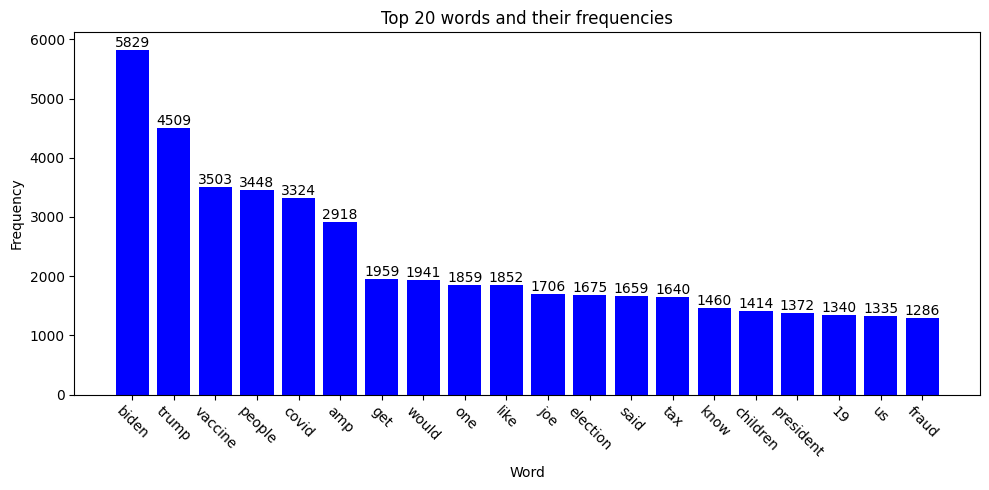

In [ ]:
common_words = get_top_n_words(fake_data_no_stopwords['text'], 20);

df_common_words = DataFrame(common_words,columns=['word','count']);
df_common_words = df_common_words.sort_values(by='count', ascending=False);

# Plot the top 20 words
n = 20;
plt.figure(figsize=(10, 5));
bars = plt.bar(df_common_words['word'][:n], df_common_words['count'][:n], color='blue');

# Add value labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom', ha='center')

plt.xlabel('Word');
plt.ylabel('Frequency');
plt.title('Top {} words and their frequencies'.format(n));
plt.xticks(rotation=-45);  # Rotate x-axis labels for better readability
plt.tight_layout();
plt.show();

Get the most frequently used groups of 2 words and plot the result

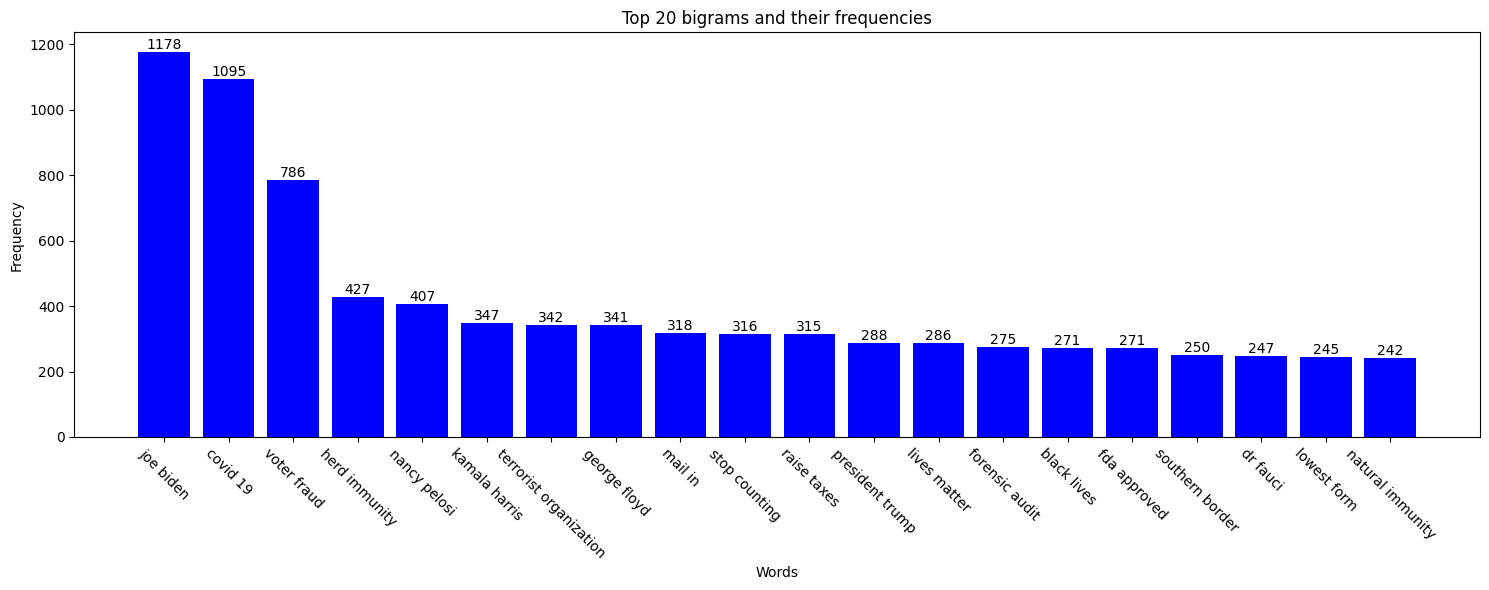

In [ ]:
common_bigrams = get_top_n_bigram(fake_data['text'], 20);
df_common_bigrams = DataFrame(common_bigrams, columns = ['words' ,'count']);

# Plot the top 20 bigrams
n = 20;
plt.figure(figsize=(15, 6));
bars = plt.bar(df_common_bigrams['words'][:n], df_common_bigrams['count'][:n], color='blue');

# Add value labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom', ha='center')

plt.xlabel('Words');
plt.ylabel('Frequency');
plt.title('Top {} bigrams and their frequencies'.format(n));
plt.xticks(rotation=-45);  # Rotate x-axis labels for better readability
plt.tight_layout();
plt.show();

Get the most frequently used groups of 3 words and plot the result


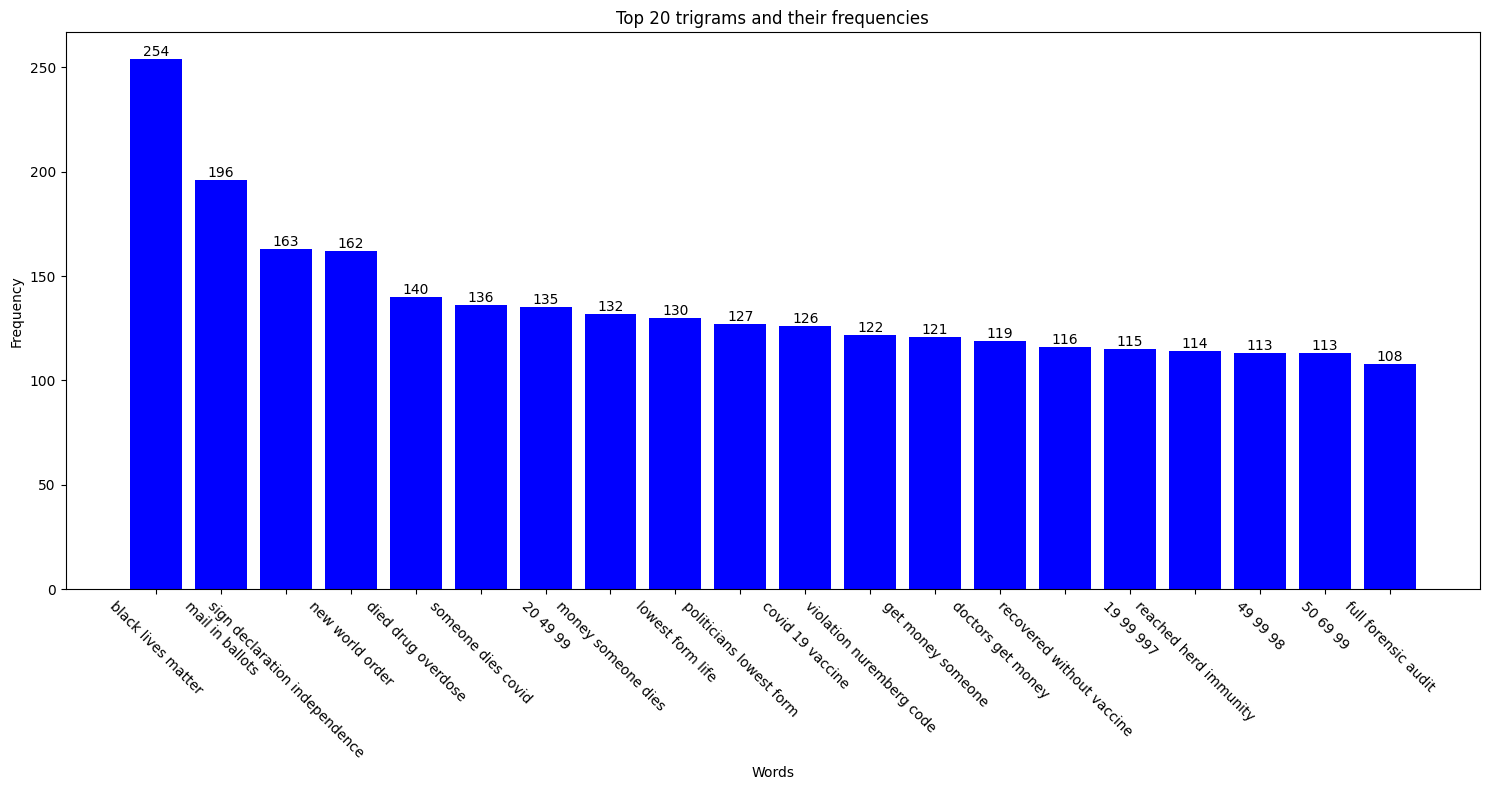

In [ ]:
common_trigrams = get_top_n_trigram(fake_data['text'], 20);
df_common_trigrams = DataFrame(common_trigrams, columns = ['words' ,'count']);

# Plot the top 20 trigrams
n = 20;
plt.figure(figsize=(15, 8));
bars = plt.bar(df_common_trigrams['words'][:n], df_common_trigrams['count'][:n], color='blue');

# Add value labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom', ha='center')

plt.xlabel('Words');
plt.ylabel('Frequency');
plt.title('Top {} trigrams and their frequencies'.format(n));
plt.xticks(rotation=-45)  # Rotate x-axis labels for better readability
plt.tight_layout();
plt.show();